In [3]:
import numpy as np 
import pandas as pd 
import os

In [4]:
pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [5]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from PIL import Image

In [6]:
# real and manipulated videos
real_videos_dir = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences"
manipulated_videos_dir = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences"

#extracted frames
output_real_dir = "/kaggle/working/frames/real"
output_manipulated_dir = "/kaggle/working/frames/manipulated"

In [7]:
os.makedirs(output_real_dir, exist_ok=True)
os.makedirs(output_manipulated_dir, exist_ok=True)

In [9]:
def extract_frames_from_videos(videos_dir, output_dir, label, max_videos):
    video_files = [f for f in os.listdir(videos_dir) if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]
    video_files = video_files[:max_videos]  # Limit to max_videos

    for video_file in video_files:
        video_path = os.path.join(videos_dir, video_file)
        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        success, image = cap.read()

        while success:
            if frame_count % int(cap.get(cv2.CAP_PROP_FPS)) == 0:
                frame_filename = f"{label}_{video_file}_frame{frame_count // int(cap.get(cv2.CAP_PROP_FPS))}.jpg"
                frame_path = os.path.join(output_dir, frame_filename)
                cv2.imwrite(frame_path, image)
            success, image = cap.read()
            frame_count += 1

        cap.release()

In [10]:
extract_frames_from_videos(real_videos_dir, output_real_dir, "real", max_videos=300)
extract_frames_from_videos(manipulated_videos_dir, output_manipulated_dir, "manipulated", max_videos=300)
print("Process of frame extraction done.")

Process of frame extraction done.


In [12]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformations with advanced augmentations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
#  dataset
dataset_dir = "/kaggle/working/frames"  # Directory where frames are saved
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [14]:
# Load Vision Transformer (ViT) model
model = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=2)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Training loop with early stopping
num_epochs = 25
best_val_accuracy = 0
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    val_loss = val_loss / len(val_loader)

   
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Early stopping and model saving
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_vit_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping due to no improvement.")
            break

    scheduler.step()

print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Epoch [1/25], Train Loss: 0.6830, Train Acc: 59.41%, Val Loss: 0.5843, Val Acc: 67.40%
Epoch [2/25], Train Loss: 0.5740, Train Acc: 67.35%, Val Loss: 0.5957, Val Acc: 63.10%
Epoch [3/25], Train Loss: 0.5270, Train Acc: 70.45%, Val Loss: 0.4995, Val Acc: 73.04%
Epoch [4/25], Train Loss: 0.5496, Train Acc: 68.03%, Val Loss: 0.5058, Val Acc: 72.11%
Epoch [5/25], Train Loss: 0.4964, Train Acc: 72.19%, Val Loss: 0.4915, Val Acc: 72.94%
Epoch [6/25], Train Loss: 0.4626, Train Acc: 74.05%, Val Loss: 0.4832, Val Acc: 73.38%
Epoch [7/25], Train Loss: 0.4569, Train Acc: 74.58%, Val Loss: 0.4735, Val Acc: 73.53%
Epoch [8/25], Train Loss: 0.4403, Train Acc: 75.72%, Val Loss: 0.4629, Val Acc: 73.38%
Epoch [9/25], Train Loss: 0.4287, Train Acc: 76.43%, Val Loss: 0.4610, Val Acc: 74.99%
Epoch [10/25], Train Loss: 0.4170, Train Acc: 77.17%, Val Loss: 0.4160, Val Acc: 77.19%
Epoch [11/25], Train Loss: 0.3924, Train Acc: 78.86%, Val Loss: 0.4028, Val Acc: 77.34%
Epoch [12/25], Train Loss: 0.3785, Train 

In [15]:
import zipfile

with zipfile.ZipFile("best_vit_model.zip", "w") as zipf:
    zipf.write("best_vit_model.pth")

In [16]:
from IPython.display import FileLink

# Show clickable download link
FileLink("best_vit_model.zip")


/kaggle/working/best_vit_model.zip

In [17]:
from sklearn.metrics import classification_report, accuracy_score

# Load the best model
model.load_state_dict(torch.load('best_vit_model.pth', weights_only=True))
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate classification metrics
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=['Real', 'Manipulated']))

# Optionally print accuracy separately
accuracy = accuracy_score(all_labels, all_predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Classification Report:
              precision    recall  f1-score   support

        Real       0.84      0.86      0.85      1907
 Manipulated       0.87      0.86      0.87      2188

    accuracy                           0.86      4095
   macro avg       0.86      0.86      0.86      4095
weighted avg       0.86      0.86      0.86      4095

Accuracy: 85.84%


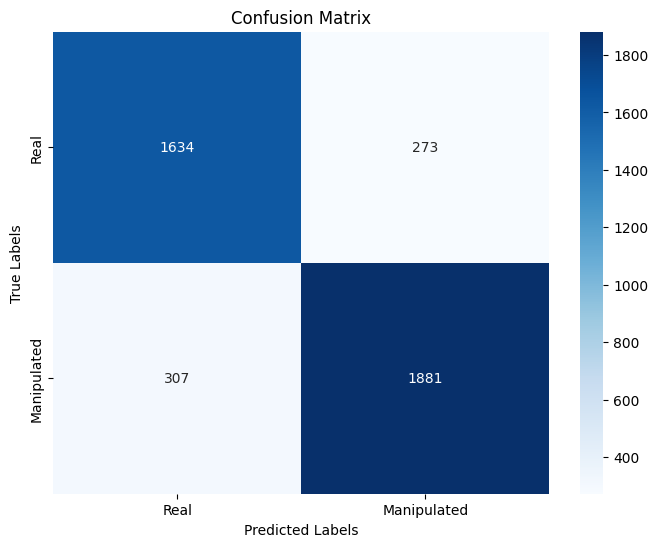

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Manipulated'], yticklabels=['Real', 'Manipulated'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

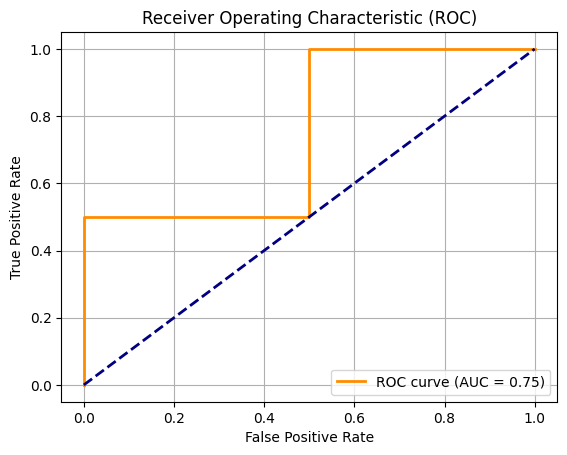

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


y_true = [0, 0, 1, 1]
y_scores = [0.1, 0.4, 0.35, 0.8]  

# Compute False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Compute AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [20]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import cv2
import timm

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define image transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the trained model
model = timm.create_model('vit_large_patch16_224', pretrained=False, num_classes=2)
# Load the trained model with weights_only=True for security
model.load_state_dict(torch.load('best_vit_model.pth', weights_only=True))
model.to(device)
model.eval()

# Function to process the video and classify each frame
def predict_video(video_path, model, transform, device):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    real_count = 0
    manipulated_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1

        # Convert frame to PIL Image and apply transformations
        image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

        # Make prediction
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)
        
        if predicted.item() == 0:
            real_count += 1
        else:
            manipulated_count += 1

    cap.release()

    # Final decision based on majority vote across all frames
    if real_count > manipulated_count:
        print(f"Result: Real video ({real_count} real frames, {manipulated_count} manipulated frames)")
        return "Real"
    else:
        print(f"Result: Manipulated video ({real_count} real frames, {manipulated_count} manipulated frames)")
        return "Manipulated"

# Test the video
video_path = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/02__kitchen_still.mp4"
result = predict_video(video_path, model, transform, device)

Result: Manipulated video (26 real frames, 829 manipulated frames)


In [21]:
video_path = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_manipulated_sequences/DFD_manipulated_sequences/01_03__hugging_happy__ISF9SP4G.mp4"
result = predict_video(video_path, model, transform, device)


Result: Manipulated video (0 real frames, 605 manipulated frames)


In [22]:
video_path = "/kaggle/input/deep-fake-detection-dfd-entire-original-dataset/DFD_original sequences/01__exit_phone_room.mp4"
result = predict_video(video_path, model, transform, device)

Result: Real video (209 real frames, 96 manipulated frames)


In [23]:
import zipfile
import os

# Extract the model file
with zipfile.ZipFile("best_vit_model.zip", "r") as zip_ref:
    zip_ref.extractall(".")

# Then load as usual
model.load_state_dict(torch.load("best_vit_model.pth", map_location=device))
model.to(device)
model.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Id